In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os
import torchinfo

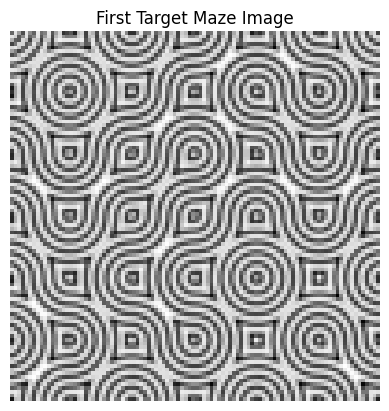

In [33]:
# Function to load and process multiple maze images
def load_maze_images(image_dir, target_size=(100, 100)):
    image_tensors = []
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])
    for filename in os.listdir(image_dir):
        if filename.endswith('d.png') or filename.endswith('n.jpg'):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image_tensor = transform(image)
            image_tensors.append(image_tensor.unsqueeze(0))  # Add batch dimension
    return torch.cat(image_tensors)  # Concatenate all images into a single tensor

# Path to the directory containing maze images
image_dir = 'training_img'

# Convert the images to a tensor
target_img = load_maze_images(image_dir).to(torch.float32)

# Visualize the first target maze image
plt.imshow(target_img[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('First Target Maze Image')
plt.axis('off')
plt.show()



In [70]:
# Assume `mazes` is a list of numpy arrays of shape (39, 39)
mazes = [np.genfromtxt(f'training/training_lab/maze{i}.txt', delimiter=' ') for i in range(1)]  # Replace with your actual data loading mechanism

# Convert mazes to PyTorch tensors
mazes = [torch.tensor(maze, dtype=torch.float32).unsqueeze(0) for maze in mazes]  # Add channel dimension and ensure float type

In [71]:
class MazeDataset(torch.utils.data.Dataset):
    def __init__(self, maze_tensors):
        self.maze_tensors = maze_tensors
    
    def __len__(self):
        return len(self.maze_tensors)
    
    def __getitem__(self, idx):
        return self.maze_tensors[idx]

# Create the dataset and dataloader
dataset = MazeDataset(mazes)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
target_img = mazes[0].unsqueeze(0).to(torch.float32)

In [72]:
class CA(nn.Module):
    def __init__(self, state_dim=16, hidden_dim=128):
        super(CA, self).__init__()
        self.state_dim = state_dim
        self.update = nn.Sequential(
            nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
            nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
            nn.ReLU(),  # nonlinearity
            nn.Conv2d(hidden_dim, state_dim, 1)  # output a residual update
        )
        self.update[0].weight.requires_grad = True  # Make the kernel learnable

    def forward(self, x, num_steps):
        alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
        frames = []
        for i in range(num_steps):
            alive_mask_pre = alive_mask(alpha=x[:, 3:4])
            update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
            x = x + update_mask * self.update(x)  # state update!
            x = x * alive_mask_pre * alive_mask(alpha=x[:, 3:4])  # a cell is either living or dead
            frames.append(x.clone())
        return torch.stack(frames)  # axes: [N, B, C, H, W] where N is # of steps
    
def random_erase(x, p=0.5, size=0.2):
    if torch.rand(1).item() < p:
        _, _, h, w = x.shape
        erase_size = int(size * min(h, w))
        x1 = np.random.randint(0, h - erase_size)
        y1 = np.random.randint(0, w - erase_size)
        x[:, :, x1:x1+erase_size, y1:y1+erase_size] = 0
    return x


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
state_dim = 16
grid_size = 39

model = CA(state_dim=state_dim, hidden_dim=128).to(device)
torchinfo.summary(model.update)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            432
├─Conv2d: 1-2                            6,272
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            2,064
Total params: 8,768
Trainable params: 8,768
Non-trainable params: 0

In [79]:
# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
state_dim = 16
grid_size = 39  # Assuming square grid

# Create the CA model
model = CA(state_dim=state_dim, hidden_dim=128).to(device)  # Move model to the appropriate device

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

# Prepare to collect images for visualization
images = []
epochs_to_save = list(range(0, 2000, 200))  # Save images every 200 epochs

# Training loop
num_epochs = 2000  # Increased epochs
for epoch in range(num_epochs):
    for batch in dataloader:
        target = batch.to(device)  # Move target maze to the appropriate device
        # grid = torch.randn(1, state_dim, grid_size, grid_size).to(device)
        grid = target_img
        # grid = torch.zeros(1, state_dim, grid_size, grid_size).to(device)  # Initialize a 100x100 grid with zeros
        # center_start = (grid_size - 8) // 2
        # grid[:, :, center_start:center_start+10, center_start:center_start+10] = target_img[:, :, center_start:center_start+10, center_start:center_start+10].repeat(1, state_dim, 1, 1)
        # grid = torch.zeros(1, state_dim, grid_size, grid_size).to(device)  # Initial state
        # grid[..., grid.shape[-2]//2, grid.shape[-1]//2] = 1  # Center pixel set to 1
        # grid = random_erase(grid)

        optimizer.zero_grad()
        output = model(grid, num_steps=50)  # Increased number of steps
        
        # Calculate the loss with respect to the target maze (using the last step output)
        loss = criterion(output[-1, :, :1, :, :], target)  # Compare only the first channel with the target
        
        loss.backward()
        optimizer.step()
    
    if epoch in epochs_to_save:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
        
        # Visualization: Collect the first channel of the first sample in the batch
        output_np = output[-1, 0, 0].detach().cpu().numpy()
        images.append(output_np)
        
        # Save model state
        torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')

# Plot all collected images in a grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(f'Epoch {epochs_to_save[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Load the model and visualize the result
def load_and_visualize_model(epoch, grid_size):
    model = CA(state_dim=state_dim, hidden_dim=128).to(device)
    model.load_state_dict(torch.load(f'model_epoch_{epoch}.pth'))
    model.eval()
    
    grid = torch.randn(1, state_dim, grid_size, grid_size).to(device)
    # grid[..., grid.shape[-2]//2, grid.shape[-1]//2] = 1  # Center pixel set to 1
    
    with torch.no_grad():
        output = model(grid, num_steps=100)
    
    output_np = output[-1, 0, 0].detach().cpu().numpy()
    
    plt.imshow(output_np, cmap='gray')
    plt.title(f'Output after reloading model at epoch {epoch}')
    plt.axis('off')
    plt.show()

# Visualize the model output after reloading at a specific epoch
# load_and_visualize_model(epoch=1800, grid_size=grid_size)

c:\Users\niedz\AppData\Local\anaconda3\envs\nn\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: Expected 3D or 4D (batch mode) tensor with optional 0 dim batch size for input, but got:[1, 0, 39, 39]